In [ ]:
# Getting the data!
# !wget https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
# !unzip ./unsplash-research-dataset-lite-latest.zip
# ''

### Goals
- Split data that cointains people with keyword
- Get the face box and save that to a dataframe
- Download the full image that has a face
- Download a crop of the face detected

### Data exploration and selection

In [1]:
import numpy as np
import pandas as pd
import glob

In [2]:
photos_df=pd.read_csv('./photos.tsv000', sep='\t', header=0)

/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
photos_df.head()

,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photographer_username,photographer_first_name,photographer_last_name,exif_camera_make,exif_camera_model,...,photo_location_longitude,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence
0,7CmlLeRipHk,https://unsplash.com/photos/7CmlLeRipHk,https://images.unsplash.com/uploads/1410881055...,2014-09-16 15:27:20,f,matthewwheeler,Matthew,Wheeler,NaN,NaN,...,NaN,NaN,NaN,2689,287.0,NaN,NaN,NaN,NaN,NaN
1,GuLir--oA7s,https://unsplash.com/photos/GuLir--oA7s,https://images.unsplash.com/photo-143990395740...,2015-08-18 13:19:37,f,coriel,Caitlin,Oriel,Apple,iPhone 5s,...,-105.279481,United States,Boulder,1669,225.0,NaN,NaN,NaN,NaN,NaN
2,acXRNRkf05c,https://unsplash.com/photos/acXRNRkf05c,https://images.unsplash.com/photo-145072995956...,2015-12-21 20:38:10,f,devinreedstair,Devin,Stair,NaN,NaN,...,NaN,NaN,NaN,14637,199.0,NaN,NaN,NaN,NaN,NaN
3,Jau3Evlt83g,https://unsplash.com/photos/Jau3Evlt83g,https://images.unsplash.com/photo-145764267222...,2016-03-10 20:46:01,f,eprev,Anton,Eprev,NIKON CORPORATION,NIKON D7000,...,4.894513,Netherlands,Amsterdam,1823,144.0,NaN,NaN,NaN,NaN,NaN
4,ob9953uWZT4,https://unsplash.com/photos/ob9953uWZT4,https://images.unsplash.com/photo-146979374302...,2016-07-29 12:04:48,t,wiradyatmika,IB,Wira Dyatmika,Canon,Canon EOS 7D,...,NaN,NaN,NaN,3202928,19083.0,photo of woman wearing grey jacket and brown c...,NaN,NaN,NaN,NaN


In [4]:
selected_urls_c = photos_df[['photo_id','photo_url','photo_image_url', 'ai_description']]
selected_urls_c.head()

,photo_id,photo_url,photo_image_url,ai_description
0,7CmlLeRipHk,https://unsplash.com/photos/7CmlLeRipHk,https://images.unsplash.com/uploads/1410881055...,NaN
1,GuLir--oA7s,https://unsplash.com/photos/GuLir--oA7s,https://images.unsplash.com/photo-143990395740...,NaN
2,acXRNRkf05c,https://unsplash.com/photos/acXRNRkf05c,https://images.unsplash.com/photo-145072995956...,NaN
3,Jau3Evlt83g,https://unsplash.com/photos/Jau3Evlt83g,https://images.unsplash.com/photo-145764267222...,NaN
4,ob9953uWZT4,https://unsplash.com/photos/ob9953uWZT4,https://images.unsplash.com/photo-146979374302...,photo of woman wearing grey jacket and brown c...


### Face processing function


In [5]:
import os
from io import BytesIO
import requests
from PIL import Image
import cv2
from IPython.display import display
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [6]:
# https://github.com/opencv/opencv/tree/master/data/haarcascades
# https://github.com/kurnianggoro/GSOC2017/tree/master/data
haarcascade = "haarcascade_frontalface_alt_tree.xml"
LBFmodel = "lbfmodel.yaml"

if (haarcascade in os.listdir(os.curdir)):
  print("File exists")
else:
  !wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_alt_tree.xml -q
  print("File downloaded")

if (LBFmodel in os.listdir(os.curdir)):
    print("File exists")
else:
    !wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
    print("File downloaded")

File exists
File exists


200


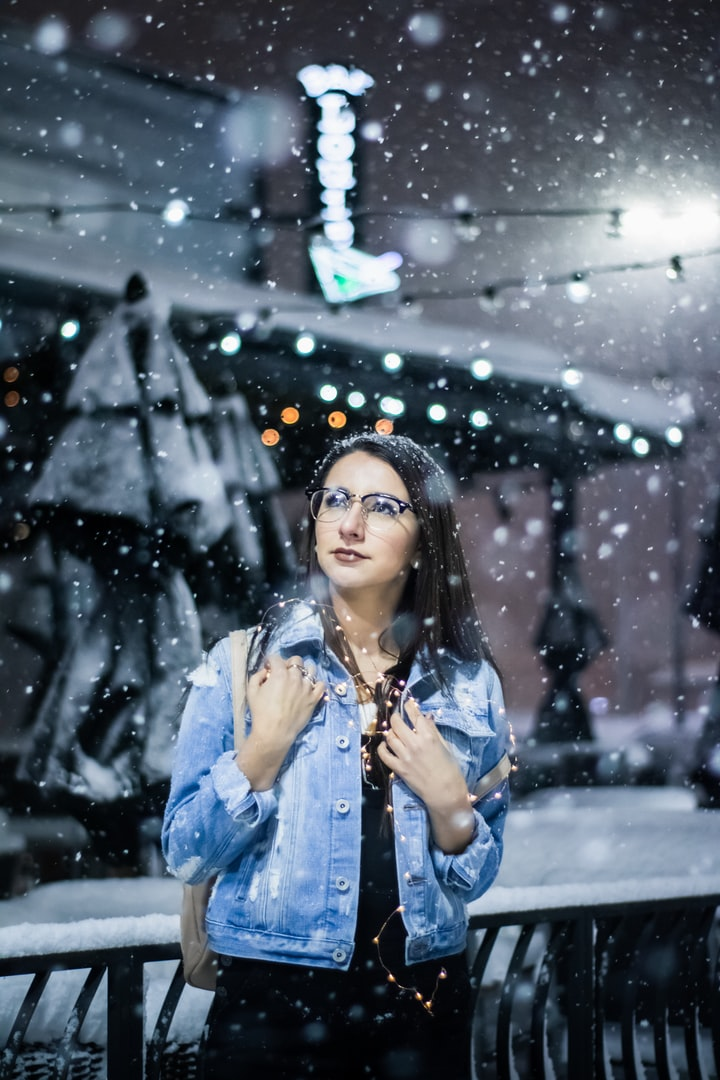

In [7]:
# open image from web link
image_bytes=requests.get('https://images.unsplash.com/photo-1584222604595-014be9ea02c2?width=720')
print(image_bytes.status_code)
image_bytes=image_bytes.content
image_stream=BytesIO(image_bytes)
img_open=Image.open(image_stream)
img_open

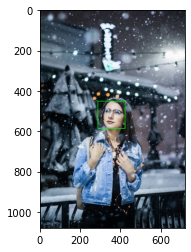

In [8]:
image_draw = np.array(img_open).copy()
detector = cv2.CascadeClassifier('./haarcascade_frontalface_alt_tree.xml')
image_gray = cv2.cvtColor(np.array(img_open), cv2.COLOR_RGB2GRAY)
faces = detector.detectMultiScale(image_gray)

for cords in faces:

  cv2.rectangle(image_draw,
                (cords[0],cords[1]),
                (cords[0]+cords[2],cords[1]+cords[3]),
                (0,255,0),2)
plt.imshow(image_draw)

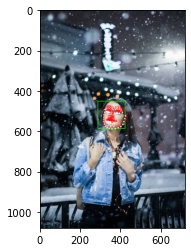

In [12]:
landmark_detector = cv2.face.createFacemarkLBF()
landmark_detector.loadModel('./lbfmodel.yaml')
  
for cords in faces:
  _, landmarks = landmark_detector.fit(image_gray, faces)

  for landmark in landmarks:
    for i,(x,y) in enumerate(landmark[0]):

      cv2.circle(image_draw, (int(x),int(y)),2,(255,255,255),2)
      
      image_draw = cv2.putText(image_draw, f"{i}", (int(x-5),int(y-5)), cv2.FONT_HERSHEY_SIMPLEX,  
                  0.5, (255, 0, 0) , 1, cv2.LINE_AA)
      
plt.imshow(image_draw)

In [13]:
def cropface(image, box, fill=50):
  shape = image.shape
  if len(shape) > 2 :
    h,w,c = shape
  else:
    h,w = shape

  x,y,w,h = box

  y_fill = y-(fill//2) if y-(fill//2) > 0 else 0
  x_fill = x-(fill//2) if x-(fill//2) > 0 else 0

  h_fill = y+h+fill 
  w_fill = x+w+fill

  return image[y_fill:(h_fill),(x_fill):(w_fill)]


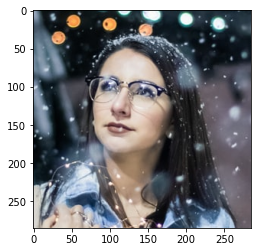

In [14]:
image_crop = np.array(img_open).copy()
plt.imshow(cropface(image_crop, faces[0], fill=100))

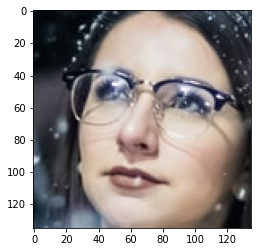

In [15]:
plt.imshow(cropface(image_crop, faces[0], fill=0))

In [35]:
def face_processing(image_url,
                  haarcascade_frontalface_path='./haarcascade_frontalface_alt_tree.xml', 
                  FacemarkLBF_path='./lbfmodel.yaml', 
                  width=1024,
                  f_landmarks=False):
  crop_faces_l=[]
  landmarks_arr = []

  detector = cv2.CascadeClassifier(haarcascade_frontalface_path)

  landmark_detector = cv2.face.createFacemarkLBF()
  landmark_detector.loadModel(LBFmodel)

  if width:
    image_url += f'?width={width}'
  try:
    image_bytes = requests.get(image_url)
    
    image_bytes = image_bytes.content
    image_stream = BytesIO(image_bytes)
    img_open = Image.open(image_stream)

    image_draw = np.array(img_open).copy()
    
    image_gray = cv2.cvtColor(np.array(img_open), cv2.COLOR_RGB2GRAY)
    faces = detector.detectMultiScale(image_gray)

    # face landmarks cropping

    for cords in faces:
      if f_landmarks:
        _, landmarks = landmark_detector.fit(image_gray, faces)
        landmarks_arr.append(landmarks)

        for landmark in landmarks:
            for i,(x,y) in enumerate(landmark[0]):

              cv2.circle(image_draw, (x,y),2,(255,255,255),2)
              image_draw = cv2.putText(image_draw, f"{i}", (int(x-5),int(y-5)), cv2.FONT_HERSHEY_SIMPLEX,  
                              0.5, (255, 0, 0) , 1, cv2.LINE_AA)

      cv2.rectangle(image_draw,
                    (cords[0],cords[1]),
                    (cords[0]+cords[2],cords[1]+cords[3]),
                    (0,255,0),2)

    for face_box in faces:
      crop_faces_l.append(cropface(np.array(img_open).copy(), face_box, fill=50))
  except:
    print(f"Error with {image_url}")
    return [], None



  return faces,landmarks_arr, image_draw, crop_faces_l

In [36]:
%time face_processing('https://images.unsplash.com/photo-1584222604595-014be9ea02c2', width=1024, f_landmarks=False)
%time face_processing('https://images.unsplash.com/photo-1584222604595-014be9ea02c2', width=256, f_landmarks=False)

CPU times: user 2.5 s, sys: 94.5 ms, total: 2.59 s
Wall time: 1.11 s
CPU times: user 909 ms, sys: 1.62 ms, total: 911 ms
Wall time: 812 ms


(array([[102, 160,  48,  48]], dtype=int32),
 [],
 array([[[27, 28, 33],
         [30, 31, 36],
         [22, 23, 28],
         ...,
         [36, 37, 42],
         [26, 27, 32],
         [22, 23, 28]],
 
        [[23, 24, 29],
         [28, 29, 34],
         [23, 24, 29],
         ...,
         [29, 30, 35],
         [24, 25, 30],
         [23, 24, 29]],
 
        [[25, 24, 29],
         [29, 28, 33],
         [27, 28, 33],
         ...,
         [25, 26, 31],
         [23, 24, 29],
         [25, 26, 31]],
 
        ...,
 
        [[35, 45, 55],
         [27, 36, 45],
         [18, 25, 31],
         ...,
         [43, 56, 64],
         [22, 36, 39],
         [ 0, 10, 12]],
 
        [[41, 54, 62],
         [22, 33, 39],
         [12, 20, 23],
         ...,
         [25, 38, 46],
         [19, 33, 36],
         [ 0, 13, 13]],
 
        [[ 1, 14, 20],
         [ 4, 15, 19],
         [ 9, 17, 20],
         ...,
         [10, 23, 31],
         [12, 26, 27],
         [ 0, 11, 11]]], dtype=

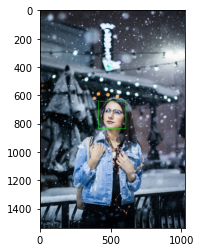

In [38]:
test_run=face_processing('https://images.unsplash.com/photo-1584222604595-014be9ea02c2', width=1024)
plt.imshow(test_run[2])

### Processing images and creating csv

In [ ]:
img_list=only_people_photos_selected['photo_image_url'].tolist()

In [ ]:
img_list[:5]

In [ ]:
result_dict = {
    'landmarks': [],
    'photo_image_url': []
}
save_path='./face_box/'
img_width=256

Path(save_path).mkdir(exist_ok=True, parents=True)
for i,url in enumerate(img_list):
  get_face_cord=face_processing(url, width=img_width)
  
  if i % 10 == 0:
    print(f"Processing {i}/{len(img_list)}")

  if len(get_face_cord[0])>0:
    cv2.imwrite(f"{os.path.join(save_path, url.split('/')[-1].split('?')[0])}.jpg", get_face_cord[1][:,:,::-1])
    result_dict['photo_image_url'].append(url)
    result_dict['landmarks'].append(get_face_cord[0])





In [ ]:
results_facebox=pd.DataFrame.from_dict(result_dict)
results_facebox.to_csv('./face_box_unsplash.csv',index=False)
results_facebox

### Downloading face crop with multiprocessing

In [ ]:
from multiprocessing import Pool, cpu_count
from functools import partial

In [ ]:
def dwl_single_facecrop(url, save_path='./face_crop'):
  Path(save_path).mkdir(exist_ok=True, parents=True)

  get_face_cord = face_processing(url)
  if len(get_face_cord[0])>0:
    for face_crop in get_face_cord[3]:
      cv2.imwrite(f"{os.path.join(save_path, url.split('/')[-1].split('?')[0])}.jpg", face_crop[:,:,::-1])

In [ ]:
pool = Pool(cpu_count())
pool.map(dwl_single_facecrop, img_list[:200])
pool.close()

In [ ]:
pool.close()

### Displaying crop faces!

In [ ]:
import os
from PIL import Image
from IPython.display import display

In [ ]:
crop_faces_path='./face_crop'
cp_list=os.listdir(crop_faces_path)

for cp in cp_list:
  cur_img = Image.open(os.path.join(crop_faces_path, cp))
  display(cur_img)